## Update
-Add Batch Normalization layer after each conv
-Add shuffle=True in model.fit() method for a better BN effect (so that we have different batch to normalize in each epoch during the training)
-You can use crf method (https://www.kaggle.com/meaninglesslives/apply-crf) to improve the result 
## Changelog
- Changed uncov to uconv, but removed the dropout in the last layer
- Corrected sanity check of predicted validation data (changed from ids_train to ids_valid)
- Used correct mask (from original train_df) for threshold tuning (inserted y_valid_ori)

In [63]:
% reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# About
Since I am new to learning from image segmentation and kaggle in general I want to share my noteook.
I saw it is similar to others as it uses the U-net approach. I want to share it anyway because:

- As said, the field is new to me so I am open to suggestions.
- It visualizes some of the steps, e.g. scaling, to learn if the methods do what I expect which might be useful to others (I call them sanity checks).
- Added stratification by the amount of salt contained in the image.
- Added augmentation by flipping the images along the y axes (thanks to the forum for clarification).
- Added dropout to the model which seems to improve performance.

In [64]:
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook

# Params and helpers

In [65]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

# Loading of training/testing ids and depths
Reading the training data and the depths, store them in a DataFrame. Also create a test DataFrame with entries from depth not in train.

In [66]:
train_df = pd.read_csv("train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

# Read images and masks
Load the images and masks into the DataFrame and divide the pixel values by 255.

In [67]:
train_df["images"] = [np.array(load_img("train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [68]:
train_df["masks"] = [np.array(load_img("train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

# Calculating the salt coverage and salt coverage classes
Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only.
Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

In [69]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [70]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

C:\Users\Ferhat\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Ferhat\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Coverage class')

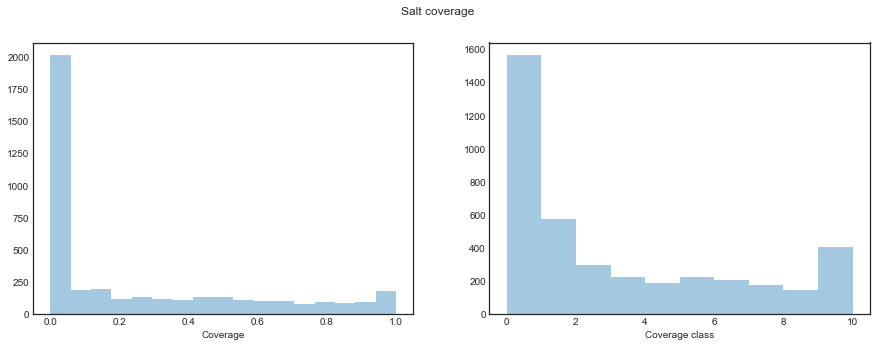

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0,0.5,'Coverage class')

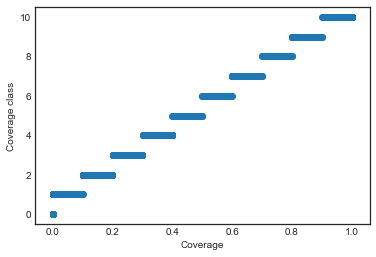

In [72]:
plt.scatter(train_df.coverage, train_df.coverage_class)
plt.xlabel("Coverage")
plt.ylabel("Coverage class")

# Plotting the depth distributions
Separatelty plotting the depth distributions for the training and the testing data.

C:\Users\Ferhat\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Ferhat\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Depth distribution')

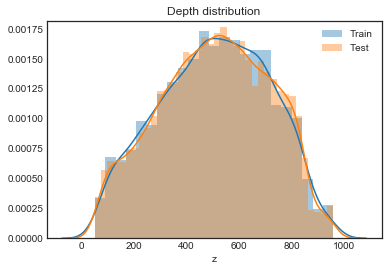

In [73]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

# Show some example images

Text(0.5,0.98,'Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

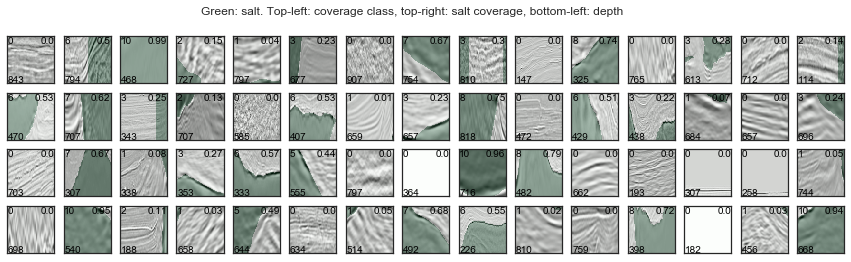

In [74]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Create train/validation split stratified by salt coverage
Using the salt coverage as a stratification criterion. Also show an image to check for correct upsampling.

In [75]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

Text(0.5,1,'Scaled image')

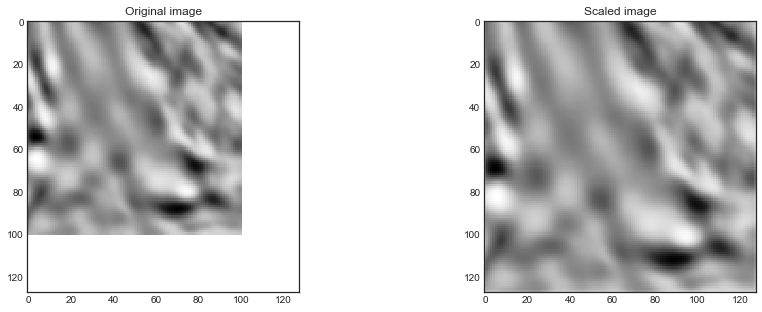

In [76]:
tmp_img = np.zeros((img_size_target, img_size_target), dtype=train_df.images.loc[ids_train[10]].dtype)
tmp_img[:img_size_ori, :img_size_ori] = train_df.images.loc[ids_train[10]]
fix, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(x_train[10].squeeze(), cmap="Greys")
axs[1].set_title("Scaled image")

# Build model

In [77]:
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

In [78]:
model = UNet((img_size_target,img_size_target,1),start_ch=16,depth=7,batchnorm=True)

In [79]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [80]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 128, 128, 16) 160         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 128, 128, 16) 64          conv2d_57[0][0]                  
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 128, 128, 16) 2320        batch_normalization_45[0][0]     
__________________________________________________________________________________________________
batch_norm

concatenate_16 (Concatenate)    (None, 64, 64, 64)   0           batch_normalization_48[0][0]     
                                                                 conv2d_88[0][0]                  
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, 64, 64, 32)   18464       concatenate_16[0][0]             
__________________________________________________________________________________________________
batch_normalization_71 (BatchNo (None, 64, 64, 32)   128         conv2d_89[0][0]                  
__________________________________________________________________________________________________
conv2d_90 (Conv2D)              (None, 64, 64, 32)   9248        batch_normalization_71[0][0]     
__________________________________________________________________________________________________
batch_normalization_72 (BatchNo (None, 64, 64, 32)   128         conv2d_90[0][0]                  
__________

# Data augmentation

In [81]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

Text(0.5,0.98,'Top row: original images, bottom row: augmented images')

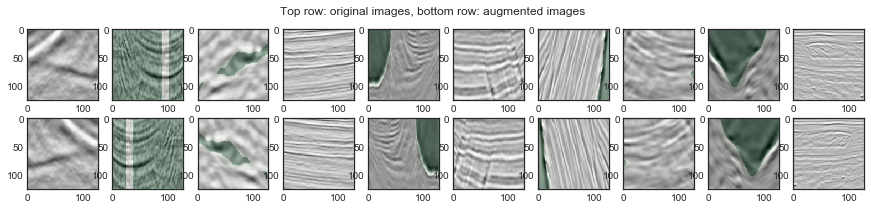

In [82]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

# Training

In [83]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr],shuffle=True)

Train on 6400 samples, validate on 800 samples
Epoch 1/200
6400/6400 [==============================] - ETA: 45:58 - loss: 1.0096 - acc: 0.47 - ETA: 23:28 - loss: 0.9264 - acc: 0.51 - ETA: 15:58 - loss: 0.8577 - acc: 0.55 - ETA: 12:12 - loss: 0.8093 - acc: 0.57 - ETA: 9:57 - loss: 0.7773 - acc: 0.5953 - ETA: 8:27 - loss: 0.7527 - acc: 0.610 - ETA: 7:22 - loss: 0.7314 - acc: 0.622 - ETA: 6:33 - loss: 0.7221 - acc: 0.630 - ETA: 5:56 - loss: 0.7064 - acc: 0.643 - ETA: 5:25 - loss: 0.6921 - acc: 0.653 - ETA: 5:00 - loss: 0.6747 - acc: 0.663 - ETA: 4:40 - loss: 0.6541 - acc: 0.677 - ETA: 4:22 - loss: 0.6447 - acc: 0.684 - ETA: 4:07 - loss: 0.6277 - acc: 0.696 - ETA: 3:53 - loss: 0.6228 - acc: 0.703 - ETA: 3:42 - loss: 0.6173 - acc: 0.710 - ETA: 3:31 - loss: 0.6163 - acc: 0.712 - ETA: 3:22 - loss: 0.6052 - acc: 0.719 - ETA: 3:14 - loss: 0.5962 - acc: 0.725 - ETA: 3:07 - loss: 0.5925 - acc: 0.731 - ETA: 3:00 - loss: 0.5912 - acc: 0.733 - ETA: 2:54 - loss: 0.5836 - acc: 0.738 - ETA: 2:48 - los

6400/6400 [==============================] - ETA: 1:11 - loss: 0.2338 - acc: 0.917 - ETA: 1:12 - loss: 0.2408 - acc: 0.907 - ETA: 1:11 - loss: 0.2589 - acc: 0.892 - ETA: 1:11 - loss: 0.2705 - acc: 0.894 - ETA: 1:11 - loss: 0.2615 - acc: 0.898 - ETA: 1:11 - loss: 0.2670 - acc: 0.893 - ETA: 1:10 - loss: 0.2664 - acc: 0.892 - ETA: 1:10 - loss: 0.2573 - acc: 0.897 - ETA: 1:10 - loss: 0.2506 - acc: 0.900 - ETA: 1:09 - loss: 0.2511 - acc: 0.901 - ETA: 1:09 - loss: 0.2681 - acc: 0.893 - ETA: 1:08 - loss: 0.2738 - acc: 0.889 - ETA: 1:08 - loss: 0.2786 - acc: 0.887 - ETA: 1:08 - loss: 0.2781 - acc: 0.888 - ETA: 1:07 - loss: 0.2783 - acc: 0.888 - ETA: 1:07 - loss: 0.2765 - acc: 0.888 - ETA: 1:07 - loss: 0.2778 - acc: 0.887 - ETA: 1:06 - loss: 0.2807 - acc: 0.885 - ETA: 1:06 - loss: 0.2808 - acc: 0.885 - ETA: 1:06 - loss: 0.2795 - acc: 0.885 - ETA: 1:05 - loss: 0.2783 - acc: 0.886 - ETA: 1:05 - loss: 0.2735 - acc: 0.889 - ETA: 1:05 - loss: 0.2738 - acc: 0.888 - ETA: 1:04 - loss: 0.2727 - acc: 0.8

6400/6400 [==============================] - ETA: 1:14 - loss: 0.1764 - acc: 0.926 - ETA: 1:12 - loss: 0.2114 - acc: 0.907 - ETA: 1:12 - loss: 0.2253 - acc: 0.894 - ETA: 1:11 - loss: 0.2159 - acc: 0.897 - ETA: 1:11 - loss: 0.2121 - acc: 0.900 - ETA: 1:10 - loss: 0.2000 - acc: 0.906 - ETA: 1:10 - loss: 0.1910 - acc: 0.913 - ETA: 1:09 - loss: 0.2066 - acc: 0.905 - ETA: 1:09 - loss: 0.2275 - acc: 0.897 - ETA: 1:09 - loss: 0.2304 - acc: 0.895 - ETA: 1:08 - loss: 0.2285 - acc: 0.897 - ETA: 1:08 - loss: 0.2279 - acc: 0.898 - ETA: 1:07 - loss: 0.2350 - acc: 0.896 - ETA: 1:07 - loss: 0.2365 - acc: 0.896 - ETA: 1:07 - loss: 0.2428 - acc: 0.895 - ETA: 1:06 - loss: 0.2492 - acc: 0.892 - ETA: 1:06 - loss: 0.2476 - acc: 0.892 - ETA: 1:06 - loss: 0.2453 - acc: 0.893 - ETA: 1:05 - loss: 0.2492 - acc: 0.893 - ETA: 1:05 - loss: 0.2496 - acc: 0.892 - ETA: 1:05 - loss: 0.2488 - acc: 0.892 - ETA: 1:04 - loss: 0.2442 - acc: 0.895 - ETA: 1:04 - loss: 0.2451 - acc: 0.894 - ETA: 1:04 - loss: 0.2441 - acc: 0.8

6400/6400 [==============================] - ETA: 1:14 - loss: 0.1314 - acc: 0.957 - ETA: 1:13 - loss: 0.2276 - acc: 0.915 - ETA: 1:12 - loss: 0.2235 - acc: 0.909 - ETA: 1:11 - loss: 0.2101 - acc: 0.915 - ETA: 1:11 - loss: 0.2353 - acc: 0.902 - ETA: 1:11 - loss: 0.2292 - acc: 0.906 - ETA: 1:10 - loss: 0.2319 - acc: 0.903 - ETA: 1:10 - loss: 0.2217 - acc: 0.907 - ETA: 1:10 - loss: 0.2185 - acc: 0.908 - ETA: 1:10 - loss: 0.2155 - acc: 0.909 - ETA: 1:09 - loss: 0.2269 - acc: 0.903 - ETA: 1:09 - loss: 0.2236 - acc: 0.905 - ETA: 1:08 - loss: 0.2317 - acc: 0.900 - ETA: 1:08 - loss: 0.2268 - acc: 0.902 - ETA: 1:07 - loss: 0.2328 - acc: 0.899 - ETA: 1:07 - loss: 0.2303 - acc: 0.901 - ETA: 1:07 - loss: 0.2301 - acc: 0.900 - ETA: 1:06 - loss: 0.2347 - acc: 0.898 - ETA: 1:06 - loss: 0.2368 - acc: 0.896 - ETA: 1:05 - loss: 0.2354 - acc: 0.897 - ETA: 1:05 - loss: 0.2346 - acc: 0.898 - ETA: 1:05 - loss: 0.2298 - acc: 0.901 - ETA: 1:04 - loss: 0.2335 - acc: 0.900 - ETA: 1:04 - loss: 0.2378 - acc: 0.8

6400/6400 [==============================] - ETA: 1:11 - loss: 0.2058 - acc: 0.905 - ETA: 1:11 - loss: 0.1994 - acc: 0.906 - ETA: 1:11 - loss: 0.1787 - acc: 0.915 - ETA: 1:10 - loss: 0.1701 - acc: 0.922 - ETA: 1:10 - loss: 0.1613 - acc: 0.925 - ETA: 1:10 - loss: 0.1656 - acc: 0.925 - ETA: 1:09 - loss: 0.1779 - acc: 0.920 - ETA: 1:09 - loss: 0.1808 - acc: 0.918 - ETA: 1:09 - loss: 0.1758 - acc: 0.920 - ETA: 1:08 - loss: 0.1792 - acc: 0.919 - ETA: 1:08 - loss: 0.1864 - acc: 0.915 - ETA: 1:08 - loss: 0.2194 - acc: 0.905 - ETA: 1:07 - loss: 0.2242 - acc: 0.902 - ETA: 1:07 - loss: 0.2259 - acc: 0.901 - ETA: 1:06 - loss: 0.2235 - acc: 0.901 - ETA: 1:06 - loss: 0.2211 - acc: 0.902 - ETA: 1:06 - loss: 0.2220 - acc: 0.901 - ETA: 1:05 - loss: 0.2186 - acc: 0.903 - ETA: 1:05 - loss: 0.2172 - acc: 0.905 - ETA: 1:05 - loss: 0.2142 - acc: 0.906 - ETA: 1:04 - loss: 0.2105 - acc: 0.908 - ETA: 1:04 - loss: 0.2116 - acc: 0.907 - ETA: 1:04 - loss: 0.2085 - acc: 0.908 - ETA: 1:03 - loss: 0.2094 - acc: 0.9

6400/6400 [==============================] - ETA: 1:12 - loss: 0.2508 - acc: 0.885 - ETA: 1:13 - loss: 0.2596 - acc: 0.883 - ETA: 1:12 - loss: 0.2216 - acc: 0.903 - ETA: 1:11 - loss: 0.2089 - acc: 0.908 - ETA: 1:11 - loss: 0.2163 - acc: 0.907 - ETA: 1:11 - loss: 0.2291 - acc: 0.899 - ETA: 1:11 - loss: 0.2269 - acc: 0.898 - ETA: 1:10 - loss: 0.2294 - acc: 0.897 - ETA: 1:10 - loss: 0.2600 - acc: 0.885 - ETA: 1:10 - loss: 0.2504 - acc: 0.890 - ETA: 1:09 - loss: 0.2461 - acc: 0.893 - ETA: 1:09 - loss: 0.2393 - acc: 0.895 - ETA: 1:08 - loss: 0.2345 - acc: 0.898 - ETA: 1:08 - loss: 0.2329 - acc: 0.898 - ETA: 1:08 - loss: 0.2379 - acc: 0.895 - ETA: 1:08 - loss: 0.2327 - acc: 0.897 - ETA: 1:07 - loss: 0.2323 - acc: 0.898 - ETA: 1:07 - loss: 0.2288 - acc: 0.900 - ETA: 1:06 - loss: 0.2245 - acc: 0.902 - ETA: 1:06 - loss: 0.2215 - acc: 0.903 - ETA: 1:05 - loss: 0.2171 - acc: 0.905 - ETA: 1:05 - loss: 0.2140 - acc: 0.907 - ETA: 1:05 - loss: 0.2126 - acc: 0.907 - ETA: 1:04 - loss: 0.2137 - acc: 0.9

6400/6400 [==============================] - ETA: 1:13 - loss: 0.1845 - acc: 0.913 - ETA: 1:12 - loss: 0.1673 - acc: 0.924 - ETA: 1:11 - loss: 0.2046 - acc: 0.903 - ETA: 1:11 - loss: 0.1923 - acc: 0.909 - ETA: 1:10 - loss: 0.1716 - acc: 0.921 - ETA: 1:10 - loss: 0.1579 - acc: 0.931 - ETA: 1:10 - loss: 0.1591 - acc: 0.931 - ETA: 1:09 - loss: 0.1541 - acc: 0.934 - ETA: 1:09 - loss: 0.1514 - acc: 0.935 - ETA: 1:09 - loss: 0.1513 - acc: 0.935 - ETA: 1:08 - loss: 0.1463 - acc: 0.937 - ETA: 1:08 - loss: 0.1540 - acc: 0.934 - ETA: 1:07 - loss: 0.1538 - acc: 0.935 - ETA: 1:07 - loss: 0.1525 - acc: 0.935 - ETA: 1:07 - loss: 0.1514 - acc: 0.935 - ETA: 1:06 - loss: 0.1542 - acc: 0.933 - ETA: 1:06 - loss: 0.1591 - acc: 0.929 - ETA: 1:06 - loss: 0.1550 - acc: 0.932 - ETA: 1:05 - loss: 0.1558 - acc: 0.931 - ETA: 1:05 - loss: 0.1521 - acc: 0.933 - ETA: 1:05 - loss: 0.1509 - acc: 0.933 - ETA: 1:04 - loss: 0.1489 - acc: 0.934 - ETA: 1:04 - loss: 0.1512 - acc: 0.933 - ETA: 1:03 - loss: 0.1510 - acc: 0.9

6400/6400 [==============================] - ETA: 1:11 - loss: 0.1666 - acc: 0.922 - ETA: 1:11 - loss: 0.1743 - acc: 0.914 - ETA: 1:11 - loss: 0.1611 - acc: 0.918 - ETA: 1:11 - loss: 0.1707 - acc: 0.921 - ETA: 1:10 - loss: 0.1559 - acc: 0.928 - ETA: 1:10 - loss: 0.1796 - acc: 0.924 - ETA: 1:10 - loss: 0.1709 - acc: 0.926 - ETA: 1:09 - loss: 0.1669 - acc: 0.928 - ETA: 1:09 - loss: 0.1617 - acc: 0.930 - ETA: 1:08 - loss: 0.1653 - acc: 0.928 - ETA: 1:08 - loss: 0.1648 - acc: 0.929 - ETA: 1:08 - loss: 0.1659 - acc: 0.927 - ETA: 1:07 - loss: 0.1654 - acc: 0.926 - ETA: 1:07 - loss: 0.1616 - acc: 0.929 - ETA: 1:07 - loss: 0.1564 - acc: 0.931 - ETA: 1:06 - loss: 0.1537 - acc: 0.931 - ETA: 1:06 - loss: 0.1549 - acc: 0.931 - ETA: 1:06 - loss: 0.1700 - acc: 0.925 - ETA: 1:05 - loss: 0.1715 - acc: 0.925 - ETA: 1:05 - loss: 0.1775 - acc: 0.921 - ETA: 1:04 - loss: 0.1803 - acc: 0.921 - ETA: 1:04 - loss: 0.1777 - acc: 0.922 - ETA: 1:04 - loss: 0.1743 - acc: 0.923 - ETA: 1:03 - loss: 0.1713 - acc: 0.9

6400/6400 [==============================] - ETA: 1:13 - loss: 0.1528 - acc: 0.933 - ETA: 1:13 - loss: 0.1349 - acc: 0.937 - ETA: 1:12 - loss: 0.1352 - acc: 0.938 - ETA: 1:12 - loss: 0.1290 - acc: 0.941 - ETA: 1:11 - loss: 0.1466 - acc: 0.929 - ETA: 1:11 - loss: 0.1430 - acc: 0.930 - ETA: 1:11 - loss: 0.1339 - acc: 0.935 - ETA: 1:10 - loss: 0.1302 - acc: 0.936 - ETA: 1:10 - loss: 0.1262 - acc: 0.939 - ETA: 1:09 - loss: 0.1264 - acc: 0.940 - ETA: 1:09 - loss: 0.1353 - acc: 0.935 - ETA: 1:09 - loss: 0.1450 - acc: 0.930 - ETA: 1:08 - loss: 0.1456 - acc: 0.930 - ETA: 1:08 - loss: 0.1456 - acc: 0.930 - ETA: 1:07 - loss: 0.1410 - acc: 0.932 - ETA: 1:07 - loss: 0.1452 - acc: 0.930 - ETA: 1:06 - loss: 0.1433 - acc: 0.931 - ETA: 1:06 - loss: 0.1424 - acc: 0.932 - ETA: 1:06 - loss: 0.1394 - acc: 0.933 - ETA: 1:05 - loss: 0.1388 - acc: 0.934 - ETA: 1:05 - loss: 0.1392 - acc: 0.934 - ETA: 1:05 - loss: 0.1474 - acc: 0.931 - ETA: 1:04 - loss: 0.1471 - acc: 0.931 - ETA: 1:04 - loss: 0.1463 - acc: 0.9

6400/6400 [==============================] - ETA: 1:12 - loss: 0.1530 - acc: 0.930 - ETA: 1:11 - loss: 0.1062 - acc: 0.952 - ETA: 1:11 - loss: 0.0929 - acc: 0.961 - ETA: 1:11 - loss: 0.0908 - acc: 0.961 - ETA: 1:10 - loss: 0.0883 - acc: 0.962 - ETA: 1:10 - loss: 0.0883 - acc: 0.961 - ETA: 1:10 - loss: 0.0874 - acc: 0.961 - ETA: 1:09 - loss: 0.0901 - acc: 0.960 - ETA: 1:09 - loss: 0.0913 - acc: 0.957 - ETA: 1:09 - loss: 0.0986 - acc: 0.956 - ETA: 1:09 - loss: 0.0972 - acc: 0.956 - ETA: 1:09 - loss: 0.1011 - acc: 0.955 - ETA: 1:08 - loss: 0.1037 - acc: 0.953 - ETA: 1:08 - loss: 0.1050 - acc: 0.953 - ETA: 1:08 - loss: 0.1081 - acc: 0.951 - ETA: 1:08 - loss: 0.1069 - acc: 0.951 - ETA: 1:07 - loss: 0.1091 - acc: 0.950 - ETA: 1:07 - loss: 0.1127 - acc: 0.947 - ETA: 1:06 - loss: 0.1093 - acc: 0.949 - ETA: 1:06 - loss: 0.1090 - acc: 0.950 - ETA: 1:05 - loss: 0.1106 - acc: 0.949 - ETA: 1:05 - loss: 0.1107 - acc: 0.949 - ETA: 1:05 - loss: 0.1133 - acc: 0.949 - ETA: 1:04 - loss: 0.1145 - acc: 0.9

6400/6400 [==============================] - ETA: 1:11 - loss: 0.0987 - acc: 0.959 - ETA: 1:11 - loss: 0.1059 - acc: 0.953 - ETA: 1:11 - loss: 0.0990 - acc: 0.952 - ETA: 1:10 - loss: 0.1295 - acc: 0.935 - ETA: 1:10 - loss: 0.1216 - acc: 0.940 - ETA: 1:10 - loss: 0.1192 - acc: 0.940 - ETA: 1:09 - loss: 0.1245 - acc: 0.940 - ETA: 1:09 - loss: 0.1349 - acc: 0.934 - ETA: 1:09 - loss: 0.1279 - acc: 0.938 - ETA: 1:08 - loss: 0.1233 - acc: 0.940 - ETA: 1:08 - loss: 0.1201 - acc: 0.942 - ETA: 1:08 - loss: 0.1180 - acc: 0.943 - ETA: 1:07 - loss: 0.1214 - acc: 0.940 - ETA: 1:07 - loss: 0.1227 - acc: 0.940 - ETA: 1:07 - loss: 0.1206 - acc: 0.942 - ETA: 1:06 - loss: 0.1253 - acc: 0.940 - ETA: 1:06 - loss: 0.1250 - acc: 0.940 - ETA: 1:06 - loss: 0.1257 - acc: 0.939 - ETA: 1:05 - loss: 0.1238 - acc: 0.940 - ETA: 1:05 - loss: 0.1252 - acc: 0.940 - ETA: 1:04 - loss: 0.1278 - acc: 0.938 - ETA: 1:04 - loss: 0.1277 - acc: 0.938 - ETA: 1:04 - loss: 0.1257 - acc: 0.939 - ETA: 1:03 - loss: 0.1285 - acc: 0.9

6400/6400 [==============================] - ETA: 1:13 - loss: 0.1197 - acc: 0.957 - ETA: 1:12 - loss: 0.1035 - acc: 0.964 - ETA: 1:12 - loss: 0.0984 - acc: 0.963 - ETA: 1:11 - loss: 0.1026 - acc: 0.958 - ETA: 1:11 - loss: 0.1076 - acc: 0.953 - ETA: 1:11 - loss: 0.1051 - acc: 0.953 - ETA: 1:11 - loss: 0.1036 - acc: 0.954 - ETA: 1:10 - loss: 0.1065 - acc: 0.953 - ETA: 1:10 - loss: 0.1022 - acc: 0.955 - ETA: 1:09 - loss: 0.0992 - acc: 0.957 - ETA: 1:09 - loss: 0.0963 - acc: 0.958 - ETA: 1:08 - loss: 0.0958 - acc: 0.957 - ETA: 1:08 - loss: 0.0935 - acc: 0.959 - ETA: 1:07 - loss: 0.0913 - acc: 0.960 - ETA: 1:07 - loss: 0.0965 - acc: 0.957 - ETA: 1:07 - loss: 0.0970 - acc: 0.956 - ETA: 1:06 - loss: 0.1020 - acc: 0.955 - ETA: 1:06 - loss: 0.1007 - acc: 0.955 - ETA: 1:06 - loss: 0.1049 - acc: 0.954 - ETA: 1:05 - loss: 0.1104 - acc: 0.952 - ETA: 1:05 - loss: 0.1143 - acc: 0.950 - ETA: 1:04 - loss: 0.1128 - acc: 0.950 - ETA: 1:04 - loss: 0.1160 - acc: 0.949 - ETA: 1:04 - loss: 0.1161 - acc: 0.9

6400/6400 [==============================] - ETA: 1:14 - loss: 0.0573 - acc: 0.975 - ETA: 1:13 - loss: 0.0661 - acc: 0.963 - ETA: 1:12 - loss: 0.0650 - acc: 0.967 - ETA: 1:12 - loss: 0.0638 - acc: 0.969 - ETA: 1:11 - loss: 0.0725 - acc: 0.965 - ETA: 1:11 - loss: 0.0729 - acc: 0.965 - ETA: 1:10 - loss: 0.0843 - acc: 0.962 - ETA: 1:10 - loss: 0.0884 - acc: 0.959 - ETA: 1:10 - loss: 0.0864 - acc: 0.959 - ETA: 1:09 - loss: 0.0913 - acc: 0.957 - ETA: 1:09 - loss: 0.0991 - acc: 0.956 - ETA: 1:08 - loss: 0.0977 - acc: 0.957 - ETA: 1:08 - loss: 0.0952 - acc: 0.958 - ETA: 1:07 - loss: 0.0937 - acc: 0.958 - ETA: 1:07 - loss: 0.0917 - acc: 0.958 - ETA: 1:07 - loss: 0.0997 - acc: 0.957 - ETA: 1:06 - loss: 0.0989 - acc: 0.957 - ETA: 1:06 - loss: 0.0986 - acc: 0.957 - ETA: 1:06 - loss: 0.0973 - acc: 0.958 - ETA: 1:05 - loss: 0.0989 - acc: 0.956 - ETA: 1:05 - loss: 0.0987 - acc: 0.956 - ETA: 1:04 - loss: 0.1002 - acc: 0.955 - ETA: 1:04 - loss: 0.0992 - acc: 0.955 - ETA: 1:04 - loss: 0.0983 - acc: 0.9

6400/6400 [==============================] - ETA: 1:12 - loss: 0.1122 - acc: 0.944 - ETA: 1:11 - loss: 0.1300 - acc: 0.936 - ETA: 1:12 - loss: 0.1120 - acc: 0.946 - ETA: 1:11 - loss: 0.1073 - acc: 0.945 - ETA: 1:11 - loss: 0.1216 - acc: 0.940 - ETA: 1:10 - loss: 0.1087 - acc: 0.948 - ETA: 1:10 - loss: 0.1031 - acc: 0.951 - ETA: 1:10 - loss: 0.0976 - acc: 0.953 - ETA: 1:09 - loss: 0.0962 - acc: 0.954 - ETA: 1:09 - loss: 0.1022 - acc: 0.951 - ETA: 1:09 - loss: 0.1004 - acc: 0.951 - ETA: 1:08 - loss: 0.1008 - acc: 0.952 - ETA: 1:08 - loss: 0.1001 - acc: 0.952 - ETA: 1:07 - loss: 0.0984 - acc: 0.953 - ETA: 1:07 - loss: 0.0961 - acc: 0.955 - ETA: 1:07 - loss: 0.0944 - acc: 0.955 - ETA: 1:06 - loss: 0.0917 - acc: 0.957 - ETA: 1:06 - loss: 0.0906 - acc: 0.957 - ETA: 1:06 - loss: 0.0886 - acc: 0.958 - ETA: 1:05 - loss: 0.0891 - acc: 0.958 - ETA: 1:05 - loss: 0.0876 - acc: 0.958 - ETA: 1:04 - loss: 0.0861 - acc: 0.958 - ETA: 1:04 - loss: 0.0946 - acc: 0.957 - ETA: 1:04 - loss: 0.0960 - acc: 0.9

6400/6400 [==============================] - ETA: 1:12 - loss: 0.0792 - acc: 0.962 - ETA: 1:12 - loss: 0.0993 - acc: 0.951 - ETA: 1:11 - loss: 0.0896 - acc: 0.954 - ETA: 1:11 - loss: 0.1061 - acc: 0.947 - ETA: 1:11 - loss: 0.1035 - acc: 0.948 - ETA: 1:10 - loss: 0.0952 - acc: 0.954 - ETA: 1:10 - loss: 0.0978 - acc: 0.952 - ETA: 1:10 - loss: 0.0974 - acc: 0.953 - ETA: 1:09 - loss: 0.0985 - acc: 0.953 - ETA: 1:09 - loss: 0.0969 - acc: 0.954 - ETA: 1:09 - loss: 0.1004 - acc: 0.951 - ETA: 1:08 - loss: 0.0969 - acc: 0.953 - ETA: 1:08 - loss: 0.0947 - acc: 0.953 - ETA: 1:07 - loss: 0.0934 - acc: 0.954 - ETA: 1:07 - loss: 0.0960 - acc: 0.953 - ETA: 1:07 - loss: 0.0929 - acc: 0.954 - ETA: 1:06 - loss: 0.0954 - acc: 0.953 - ETA: 1:06 - loss: 0.0941 - acc: 0.953 - ETA: 1:06 - loss: 0.0918 - acc: 0.954 - ETA: 1:05 - loss: 0.0898 - acc: 0.955 - ETA: 1:05 - loss: 0.0899 - acc: 0.955 - ETA: 1:04 - loss: 0.0875 - acc: 0.956 - ETA: 1:04 - loss: 0.0860 - acc: 0.956 - ETA: 1:04 - loss: 0.0858 - acc: 0.9

6400/6400 [==============================] - ETA: 1:12 - loss: 0.0380 - acc: 0.976 - ETA: 1:12 - loss: 0.0485 - acc: 0.972 - ETA: 1:11 - loss: 0.0518 - acc: 0.970 - ETA: 1:11 - loss: 0.0488 - acc: 0.972 - ETA: 1:11 - loss: 0.0477 - acc: 0.972 - ETA: 1:10 - loss: 0.0557 - acc: 0.971 - ETA: 1:10 - loss: 0.0564 - acc: 0.970 - ETA: 1:10 - loss: 0.0560 - acc: 0.970 - ETA: 1:09 - loss: 0.0551 - acc: 0.970 - ETA: 1:09 - loss: 0.0549 - acc: 0.970 - ETA: 1:08 - loss: 0.0573 - acc: 0.969 - ETA: 1:08 - loss: 0.0602 - acc: 0.968 - ETA: 1:08 - loss: 0.0584 - acc: 0.968 - ETA: 1:07 - loss: 0.0580 - acc: 0.968 - ETA: 1:07 - loss: 0.0580 - acc: 0.968 - ETA: 1:07 - loss: 0.0598 - acc: 0.967 - ETA: 1:06 - loss: 0.0607 - acc: 0.967 - ETA: 1:06 - loss: 0.0620 - acc: 0.966 - ETA: 1:06 - loss: 0.0613 - acc: 0.966 - ETA: 1:05 - loss: 0.0603 - acc: 0.967 - ETA: 1:05 - loss: 0.0599 - acc: 0.967 - ETA: 1:04 - loss: 0.0591 - acc: 0.968 - ETA: 1:04 - loss: 0.0583 - acc: 0.968 - ETA: 1:04 - loss: 0.0596 - acc: 0.9

6400/6400 [==============================] - ETA: 1:12 - loss: 0.0482 - acc: 0.971 - ETA: 1:12 - loss: 0.0409 - acc: 0.975 - ETA: 1:11 - loss: 0.0466 - acc: 0.975 - ETA: 1:11 - loss: 0.0450 - acc: 0.976 - ETA: 1:11 - loss: 0.0496 - acc: 0.972 - ETA: 1:10 - loss: 0.0479 - acc: 0.972 - ETA: 1:10 - loss: 0.0496 - acc: 0.972 - ETA: 1:10 - loss: 0.0490 - acc: 0.972 - ETA: 1:09 - loss: 0.0477 - acc: 0.973 - ETA: 1:09 - loss: 0.0512 - acc: 0.971 - ETA: 1:08 - loss: 0.0505 - acc: 0.972 - ETA: 1:08 - loss: 0.0489 - acc: 0.973 - ETA: 1:08 - loss: 0.0487 - acc: 0.973 - ETA: 1:07 - loss: 0.0504 - acc: 0.972 - ETA: 1:07 - loss: 0.0522 - acc: 0.971 - ETA: 1:07 - loss: 0.0516 - acc: 0.971 - ETA: 1:06 - loss: 0.0523 - acc: 0.971 - ETA: 1:06 - loss: 0.0528 - acc: 0.971 - ETA: 1:05 - loss: 0.0522 - acc: 0.971 - ETA: 1:05 - loss: 0.0530 - acc: 0.970 - ETA: 1:05 - loss: 0.0537 - acc: 0.970 - ETA: 1:04 - loss: 0.0539 - acc: 0.970 - ETA: 1:04 - loss: 0.0531 - acc: 0.970 - ETA: 1:04 - loss: 0.0526 - acc: 0.9

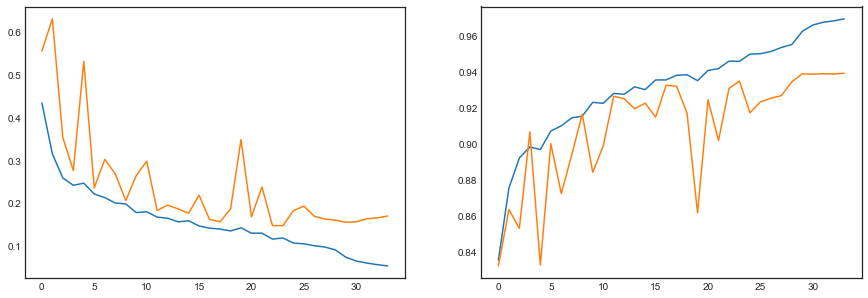

In [84]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")

In [85]:
model = load_model("./keras.model")

# Predict the validation set to do a sanity check
Again plot some sample images including the predictions.

In [86]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

Text(0.5,0.98,'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

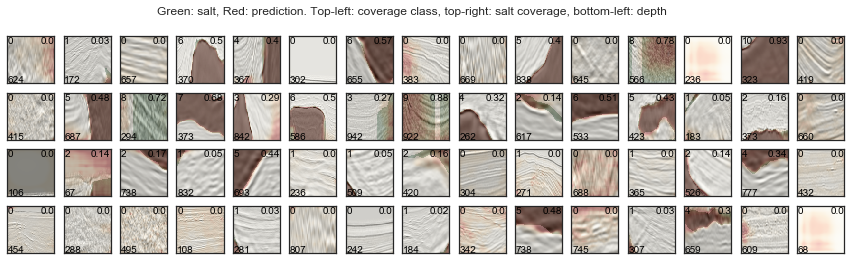

In [87]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(pred, alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Scoring
Score the model and do a threshold optimization by the best IoU.

In [88]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [89]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

In [90]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

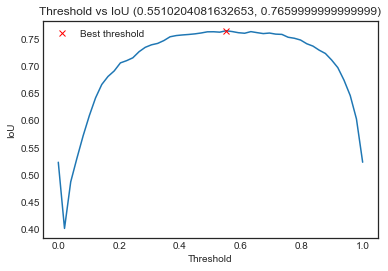

In [91]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

# Another sanity check with adjusted threshold
Again some sample images with the adjusted threshold.

Text(0.5,0.98,'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

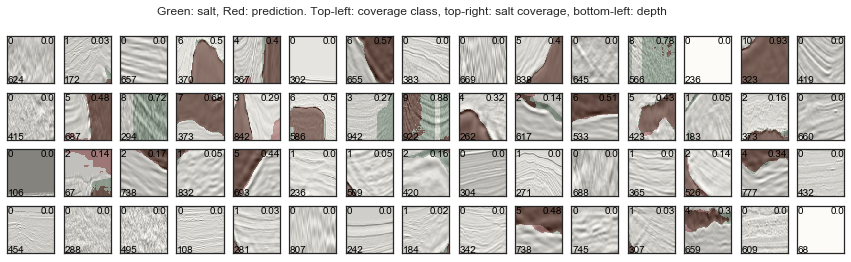

In [92]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Submission
Load, predict and submit the test image predictions.

In [93]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [94]:
x_test = np.array([upsample(np.array(load_img("test/images/{}.png".format(idx), grayscale=True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [95]:
preds_test = model.predict(x_test)

In [96]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [97]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission_din_he_v2.csv')